In [1]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pickle

from utils.accuracy_95 import my_eval, loss_and_acc, load_history, compare

data_dir = "weights/"

In [2]:
def create_bench_model():
    inputs = Input(shape = (32,32,3))
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(inputs)
    x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
    x = Dropout(0.25)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024,activation = "relu")(x)
    x = Dropout(0.25)(x)
    y = Dense(10,activation = "softmax")(x)
    return Model(inputs, y)

In [3]:
(x_train_raw, y_train_raw), (x_test_raw,y_test_raw) = cifar10.load_data()
y_train = to_categorical(y_train_raw)
y_test = to_categorical(y_test_raw)
x_train = x_train_raw / 255
x_test  = x_test_raw / 255

In [4]:
batch_size = 500
epochs = 10
steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = y_test.shape[0] // batch_size

Epoch 1/10
100/100 [==============================] - 14s 105ms/step - loss: 2.1582 - accuracy: 0.1679 - val_loss: 1.8692 - val_accuracy: 0.2982
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 1.6664 - accuracy: 0.3640 - val_loss: 1.5376 - val_accuracy: 0.4376
Epoch 3/10
100/100 [==============================] - 10s 103ms/step - loss: 1.3873 - accuracy: 0.4829 - val_loss: 1.2984 - val_accuracy: 0.5373
Epoch 4/10
100/100 [==============================] - 10s 102ms/step - loss: 1.1982 - accuracy: 0.5577 - val_loss: 1.1787 - val_accuracy: 0.5866
Epoch 5/10
100/100 [==============================] - 10s 103ms/step - loss: 1.0643 - accuracy: 0.6160 - val_loss: 1.0250 - val_accuracy: 0.6477
Epoch 6/10
100/100 [==============================] - 10s 103ms/step - loss: 0.9260 - accuracy: 0.6675 - val_loss: 0.9682 - val_accuracy: 0.6611
Epoch 7/10
100/100 [==============================] - 10s 105ms/step - loss: 0.8556 - accuracy: 0.6952 - val_loss: 0.8670 - val_ac

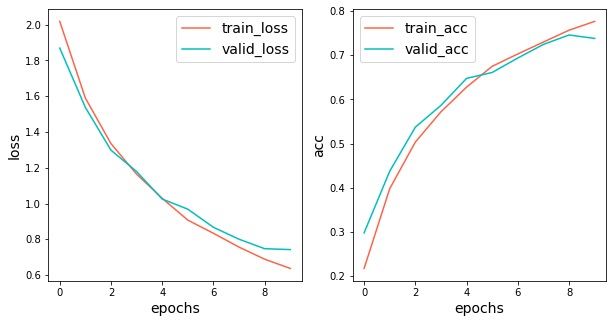

In [5]:
model = create_bench_model()
model.compile(loss = "categorical_crossentropy", 
              optimizer = Adam(), 
              metrics = ["accuracy"])
# .flow() numpyデータとラベルの配列を受け取り，拡張/正規化したデータのバッチを生成する
train_gen = ImageDataGenerator().flow(x_train,y_train, batch_size)
val_gen = ImageDataGenerator().flow(x_test,y_test, batch_size)
history = model.fit(train_gen,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_gen,
                    validation_steps=validation_steps)

### 評価と保存
my_eval(model, x_test, y_test)
loss_and_acc(history, "bench")
model.save(data_dir + "first_bench.hdf5")